In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/outta/clothes_segmentation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/outta/clothes_segmentation


In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.functional import F
from tqdm.auto import tqdm

from codes.load_testset import load_testset
from codes.show_result import show_segment
from models.u2_net import U2NET_lite
from loss.scloss import SCLoss

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model = U2NET_lite(7).to(device=device)

In [6]:
train_loader, valid_loader = load_testset('../outta_3_project/dataset/G2_train.h5', 8000, 2000)
# 개인 데이터셋 경로로 지정할 것

torch.Size([8000, 3, 128, 128]) torch.Size([8000, 128, 128])


In [14]:
test_input = None
test_label = None
for i, j in valid_loader:
    test_input = i[0]
    test_label = j[0]

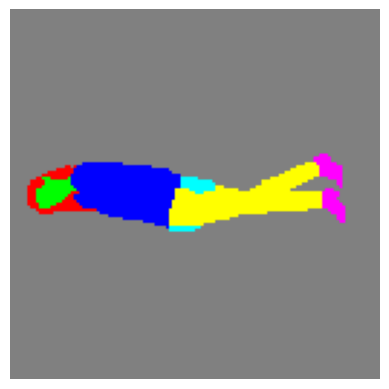

In [17]:
show_segment(test_label)

In [7]:
criterion = CrossEntropyLoss()
sc_loss = SCLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [28]:
def convert_7channel_to_1channel(tensor):
    """
    7채널 이미지에 대해 Softmax를 적용하고, 픽셀별로 가장 값이 큰 채널의 인덱스를 1채널 이미지로 변환하는 함수.

    Args:
        tensor (torch.Tensor): [B, 7, H, W] 크기의 7채널 이미지 텐서.

    Returns:
        torch.Tensor: [B, H, W] 크기의 1채널 이미지 텐서. 각 픽셀 값은 가장 큰 소프트맥스 값을 가진 채널의 인덱스.
    """
    # 각 채널에 Softmax 적용 (dim=1은 채널 차원에 대해 Softmax를 적용)
    softmax_tensor = torch.softmax(tensor, dim=1)

    # 픽셀별로 가장 값이 큰 채널의 인덱스를 얻음
    _, indices = torch.max(softmax_tensor, dim=1)  # dim=1에서 최대값의 인덱스를 얻음

    return indices


In [42]:
model.load_state_dict(torch.load('../../../../model_5.pth'))

<All keys matched successfully>

In [43]:
model.to(device)

U2NET(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (stage1): RSU(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1d): REBNCONV(
      (conv_s1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(1

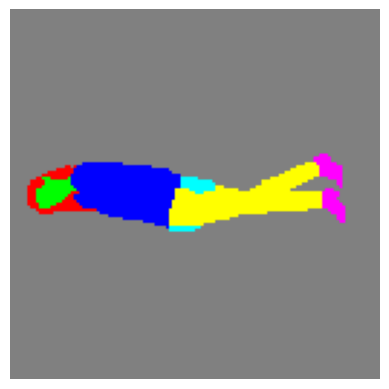

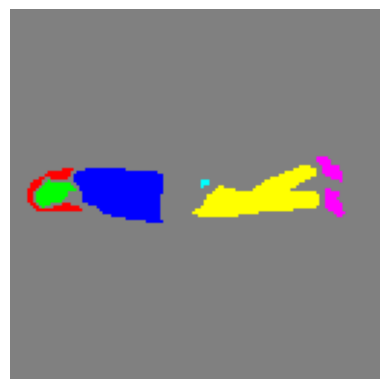

In [51]:
show_segment(test_label)
with torch.no_grad():
    model.eval()
    output = model(test_input.unsqueeze(0).to(device))
    output = torch.softmax(output, dim = 1).squeeze(0)
    image = torch.zeros((128, 128))
    for i in range(7):
        out = output[i]
        image[out > 0.9] = i
    show_segment(image)

In [8]:
def train_valid(model, criterion, sc_loss, optimizer, trainloader, validloader, num_epochs=1):
    count = 0
    train_losses = []
    valid_losses = []

    for epoch in tqdm(range(num_epochs)):
        train_losses.append(epoch_loop(model, criterion, sc_loss, optimizer, trainloader))
        valid_losses.append(epoch_loop(model, criterion, sc_loss, optimizer, validloader, valid = True))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Valid Loss: {valid_losses[-1]}')


        if train_losses[-1] > valid_losses[-1]:
            count += 1
            if count > 2:
                print('early stop')


        if min(valid_losses) == valid_losses[-1]:
            torch.save(model.state_dict(), f'../../../../model_{epoch}.pth')

        show_segment(test_label)
        with torch.no_grad():
            model.eval()
            output = model()
            convert_7channel_to_1channel(output)
    return train_losses, valid_losses


In [9]:
def epoch_loop(model, criterion, sc_loss, optimizer, dataloader, valid=False):
    epoch_loss = 0

    if valid:
        model.eval()
    else:
        model.train()

    for inputs, targets in tqdm(dataloader, leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.long()

        # Forward pass
        outputs = model(inputs)

        # Main Loss 계산 (CrossEntropyLoss)
        ce_loss = criterion(outputs, targets)

        # SCLoss 계산
        outputs_probs = F.softmax(outputs, dim=1)
        targets_onehot = F.one_hot(targets, num_classes=outputs.shape[1]).permute(0, 3, 1, 2).float()
        sc_loss_value = sc_loss(outputs_probs, targets_onehot)

        loss = ce_loss + sc_loss_value

        if not valid:
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()

        del inputs, targets, outputs, ce_loss, outputs_probs, targets_onehot, sc_loss_value, loss
        torch.cuda.empty_cache()

    return epoch_loss/len(dataloader)

In [10]:
train_valid(model, criterion, sc_loss, optimizer, train_loader, valid_loader, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.2797212758660316, Valid Loss: 0.13473976131469484
early stop


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.11508065968751907, Valid Loss: 0.11400977250129457
early stop


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.09729194551706315, Valid Loss: 0.09374897796956319
early stop


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.08852854633331299, Valid Loss: 0.08914071167745287


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.0819344749301672, Valid Loss: 0.0862020795780515


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.07753324747085572, Valid Loss: 0.08402628203233083


  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 